I was having issues runnng certain packages on the cloud instance I had for training the network, so I saved the embeddings separately and am using those embeddings here to train the network.

# Import and load dataset

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from keras.preprocessing import text, sequence
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Embedding, SpatialDropout1D, concatenate, Dense
from keras.layers import Bidirectional, LSTM, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.models import Model
from keras import optimizers
import gc
from keras import backend as K
from sklearn.model_selection import KFold
# Checkpoint the weights when validation accuracy improves
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
import datetime

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#This dataset contains new features, ascii text converted to unicode and standardized
nrows= 5000
train = pd.read_csv('Data/train_processed_stage1.csv', nrows=nrows)
print('Train dataset contains {} rows and {} columns'.format(*train.shape))

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
meta_features_cols = ['total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks', 'num_question_marks', \
 'num_punctuation', 'num_symbols', 'num_words', 'num_unique_words', 'words_vs_unique', 'num_smilies', 'ant_slash_n', \
 'nb_fk', 'nb_sk', 'nb_dk', 'nb_you', 'nb_ng', 'nb_mother', 'start_with_columns', 'has_timestamp', 'has_date_long', \
 'has_date_short', 'has_http', 'has_mail', 'has_image', 'has_ip', 'has_emphasize_equal', 'has_emphasize_quotes', \
 'has_star', 'unknown_fasttext']

X_clean_text_df = train[['id','clean_text']].fillna('something')
X_meta_feats_df = train[meta_features_cols].fillna('something')
y = train[class_names]
print ('X_clean_text_df contains {} rows and {} columns'.format(*X_clean_text_df.shape))
print ('X_meta_feats_df contains {} rows and {} columns'.format(*X_meta_feats_df.shape))
print ('y contains {} rows and {} columns'.format(*y.shape))

Train dataset contains 5000 rows and 39 columns
X_clean_text_df contains 5000 rows and 2 columns
X_meta_feats_df contains 5000 rows and 30 columns
y contains 5000 rows and 6 columns


In [3]:
source_file_name = "Data/embeddings/embeddings_matrix.pickle"
with open(source_file_name, 'rb') as handle:
    embedding_matrix = pickle.load(handle)

# Define functions
## Convert text to vectors

In [4]:
#This allows to vectorize a text corpus, by turning each text into a sequence of integers 
src_vocab_size = 10000
# src_vocab_size = 283759
def create_tokenizer():
    #consider only the top 10000 words in the dataset
    tokenizer = text.Tokenizer(num_words=src_vocab_size)
    tokenizer.fit_on_texts(list(X_clean_text_df['clean_text']))
    return tokenizer

def find_max_len(percentile=0.9):
    #since each of the reviews can be of varying length. we will convert them to be of same length by padding.
    #lets find out what should be the length of each reviews
    #find the length
    X_clean_text_df['text_length'] = X_clean_text_df['clean_text'].apply(len)

    # use the 90th percentile to pad sequences
    maxlen = int(X_clean_text_df.text_length.quantile(percentile)) # 90th percentile
    return maxlen

# encode and pad sequences
def encode_sequences(tokenizer, length):
    #map words to integers as needed for modelling
    X_train_sequence = tokenizer.texts_to_sequences(X_clean_text_df['clean_text'])

    # pad sequences with 0 values
    #it will take each review and make them to be of 836 words.
    #if the review is less than 836 words it will pad zeroes at the start and append the reviews to the end.
    #if the review is more than 836 words, the words beyond 600 will be truncated
    X_train_padded_seq = sequence.pad_sequences(X_train_sequence, maxlen=length)
    return X_train_padded_seq

## Model related

In [5]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.max_score = 0
        self.not_better_count = 0

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=1)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            if (score > self.max_score):
                print("*** New High Score (previous: %.6f) \n" % self.max_score)
#                 model.save_weights("best_weights.h5")
                model.save_weights(bst_model_path)
                self.max_score=score
                self.not_better_count = 0
            else:
                self.not_better_count += 1
                if self.not_better_count > 3:
                    print("Epoch %05d: early stopping, high score = %.6f" % (epoch,self.max_score))
                    self.model.stop_training = True

def get_model(features, max_features, clipvalue=1.,num_filters=40,dropout=0.5,embedding_dims=501):
    features_input = Input(shape=(features.shape[1],))
    inp = Input(shape=(maxlen, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    #There are multiple ways to represent a word as a vector: tfidf, bag of words, one-hot encoding etc. These are high
    #dimensional sparse representation of the data. The other way to reporesent a word as a vector is using word embeddings-
    #these are dense vectors low dimensional vectors in the form of 256 dim, 512 dim or 1024 dimensions. Word embeddings
    #pack more information into fewer dimensions.
    #There are 2 ways to obtain word embeddings:
    #1. Learn word embeddings as part of the main task at hand such as classification.
    #2. Load a pre trained word embedding. These embeddings are useful when there is less training data.
    
    #src_vocab_size represents what top n features we are using from the dataset
    #embedding_dims represents the dimensions of the fasttext word embedding.
    #embedding_matrix contains the embedding vectors for our training dataset
    #by setting trainable=False, we are saying do not train this layer.
    
#     x = Embedding(src_vocab_size, embedding_dims, weights=[embedding_matrix], trainable=False)(inp)
    x = Embedding(max_features, embedding_dims, weights=[embedding_matrix], trainable=False)(inp)
    
    # Uncomment for best result
    # Layer 2: SpatialDropout1D(0.5)
    x = SpatialDropout1D(dropout)(x)
    
    # Uncomment for best result
    # Layer 3: Bidirectional CuDNNLSTM
    #a Bidirectional layer creates a second separate instance of the recurrent layer and uses one instance for processing
    #the input sequences in chronological order and the other instance for processing the input sequences in reversed
    #order. This looks at its input sequence both ways obtaining potentially richer reprsentations and capturing patterns
    #that may have been missed by the chronological order version alone.
    #create bidirectional layer with 40 such instances
#     x = Bidirectional(LSTM(num_filters, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(num_filters, return_sequences=True))(x)


    # Layer 4: Bidirectional CuDNNGRU
#     x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    x, x_h, x_c = Bidirectional(CuDNNGRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    # Layer 5: A concatenation of the last state, maximum pool, average pool and 
    # two features: "Unique words rate" and "Rate of all-caps words"
    
    #if you want to detect the presence of something in your sequences, max pooling seems a good option.
    #But if the contribution of the entire sequence seems important to your result, then average pooling sounds reasonable.
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, max_pool,features_input])
    
    # Layer 6: output dense layer.
    outp = Dense(6, activation="sigmoid")(x)

    model = Model(inputs=[inp,features_input], outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    
    return model

def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Convert clean_text to vectors/tokenize

In [6]:
tokenizer = create_tokenizer()
print('Number of unique tokens created from the training dataset is {}'.format(len(tokenizer.word_index)))

maxlen = find_max_len()
print('Sequences will be of length - {}'.format(maxlen))

X_train_padded_seq = encode_sequences(tokenizer, maxlen)

word_index = tokenizer.word_index

#len(word_index) is 22966 and src_vocab_size is 10000
nb_words = min(src_vocab_size, len(word_index)) + 1

Number of unique tokens created from the training dataset is 22966
Sequences will be of length - 837


# Build Model

In [7]:
model = get_model(X_meta_feats_df.values, nb_words)
print(model.summary())
plot_model(model, to_file='Data/model.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 837)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 837, 501)     5010501     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 837, 501)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 837, 80)      173440      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

In [8]:
X_meta_feats_df.shape, src_vocab_size, embedding_matrix.shape

((5000, 30), 10000, (10001, 501))

Start time is 11:27:52 AM
Working on fold - 1
Train on 1674 samples, validate on 826 samples
Epoch 1/2
2500/2500 [==============================] - 35s 14ms/step

 ROC-AUC - epoch: 1 - score: 0.669275 

*** New High Score (previous: 0.000000) 

Epoch 2/2
2500/2500 [==============================] - 42s 17ms/step

 ROC-AUC - epoch: 2 - score: 0.829705 

*** New High Score (previous: 0.669275) 

History is {'val_loss': [0.13270417227439096, 0.11781014081713073], 'val_acc': [0.9661016875548744, 0.9671105687612482], 'loss': [0.2823842866446382, 0.13788812771982545], 'acc': [0.8969534072967128, 0.9610712935562772]}


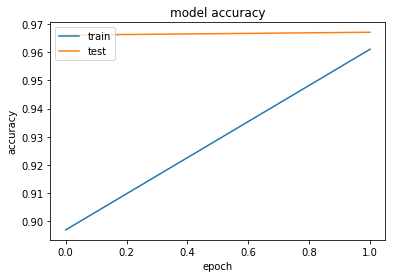

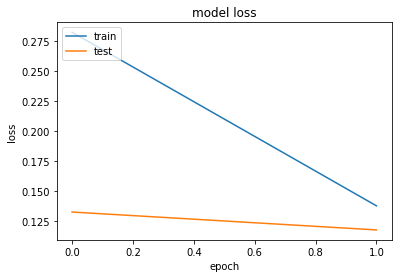

Working on fold - 2
Train on 1674 samples, validate on 826 samples
Epoch 1/2
2500/2500 [==============================] - 44s 18ms/step

 ROC-AUC - epoch: 1 - score: 0.543700 

*** New High Score (previous: 0.000000) 

Epoch 2/2
2500/2500 [==============================] - 49s 19ms/step

 ROC-AUC - epoch: 2 - score: 0.785574 

*** New High Score (previous: 0.543700) 



In [ ]:
currentDT = datetime.datetime.now()
print('Start time is {}'.format(currentDT.strftime("%I:%M:%S %p")))

batch_size = 32
bst_model_path="Data\Weights\weights.best.hdf5"

# Use epochs=100 with early exiting for best score.
epochs = 2
gc.collect()
K.clear_session()

# Change to 10
num_folds = 2 #number of folds
history = History()
# predict = np.zeros((test.shape[0],6))

# Uncomment for out-of-fold predictions
# scores = []
# oof_predict = np.zeros((train.shape[0],6))

kf = KFold(n_splits=num_folds, shuffle=True, random_state=239)

ctr = 0
for train_index, test_index in kf.split(X_train_padded_seq):
    ctr += 1
    print ('Working on fold - {}'.format(ctr))
    
    
    kfold_y_train, kfold_y_test = y.iloc[train_index], y.iloc[test_index]
    kfold_X_train = X_train_padded_seq[train_index]
    kfold_X_meta_features = X_meta_feats_df.iloc[train_index]
    
    kfold_X_valid = X_train_padded_seq[test_index]
    kfold_X_valid_meta_features = X_meta_feats_df.iloc[test_index] 
    
    gc.collect()
    K.clear_session()
    
    model = get_model(X_meta_feats_df.values, nb_words)
    
    ra_val = RocAucEvaluation(validation_data=([kfold_X_valid, kfold_X_valid_meta_features], kfold_y_test), interval = 1)

    # checkpoint
#     bst_model_path="Data\Weights\weights.best.hdf5"
#     checkpoint = ModelCheckpoint(bst_model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    
#     callbacks_list = [checkpoint, ra_val]
    callbacks_list = [ra_val, history]
    
#     history = model.fit([kfold_X_train, kfold_X_meta_features], kfold_y_train, batch_size=batch_size, epochs=epochs, verbose=1,
#              callbacks = callbacks_list)
    model.fit([kfold_X_train, kfold_X_meta_features], kfold_y_train, batch_size=batch_size, epochs=epochs, verbose=1,
             callbacks = callbacks_list, validation_split=0.33)
    gc.collect()
    
    model.load_weights(bst_model_path)
    print('History is {}'.format(history.history))
    #     model.load_weights("Data\Weights\best_weights.h5")
    
#     print(history.history.keys())
    # summarize history for accuracy
    plot_history(history)
    
    
#     predict += model.predict([x_test,test_features], batch_size=batch_size,verbose=1) / num_folds
    
    #gc.collect()
    # uncomment for out of fold predictions
    #oof_predict[test_index] = model.predict([kfold_X_valid, kfold_X_valid_features],batch_size=batch_size, verbose=1)
    #cv_score = roc_auc_score(kfold_y_test, oof_predict[test_index])
    
    #scores.append(cv_score)
    #print('score: ',cv_score)

print("Done")
#print('Total CV score is {}'.format(np.mean(scores)))  
currentDT = datetime.datetime.now()
print('End time is {}'.format(currentDT.strftime("%I:%M:%S %p")))